In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD'

In [2]:
import tensorflow as tf
import keras
from keras import layers
import pathlib

from src.frame_generator import FrameGenerator
from blocks import Conv2Plus1D, ResizeVideo, add_residual_block
from src.config import DATA_PATH, SPLITS
from src.plot_utils import plot_history
import numpy as np

2023-04-29 19:09:26.801367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 19:09:26.938441: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-29 19:09:27.444708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2023-04-29 19:09:27.444790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

2023-04-29 19:09:28.553252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 19:09:28.579952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 19:09:28.580230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [5]:
subset_size = 10
subset = f"subset_{subset_size}_lsa_64"
model_type = "3DCNN"
model_name = "3dcnn"

In [6]:
subset_paths = {}
for sp in SPLITS:
    subset_paths[sp] = pathlib.Path(os.path.join(DATA_PATH, subset, sp))

In [7]:
n_frames = 10
batch_size = 16

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

2023-04-29 19:09:28.700016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 19:09:28.701257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 19:09:28.701502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 19:09:28.701704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [9]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [10]:
frames, label = next(iter(train_ds))
model.build(frames)

2023-04-29 19:09:43.608307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 1000
2023-04-29 19:09:51.178503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 1000
2023-04-29 19:10:03.743480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8 of 1000
2023-04-29 19:10:12.084073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 10 of 1000
2023-04-29 19:10:24.098930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 13 of 1000
2023-04-29 19:10:31.215985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15 of 1000
2023-04-29 19:10:42.898024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (th

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 10, 224, 224  3152        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 224, 224  64         ['conv2_plus1d[0][0]']           
 alization)                     , 16)                                                         

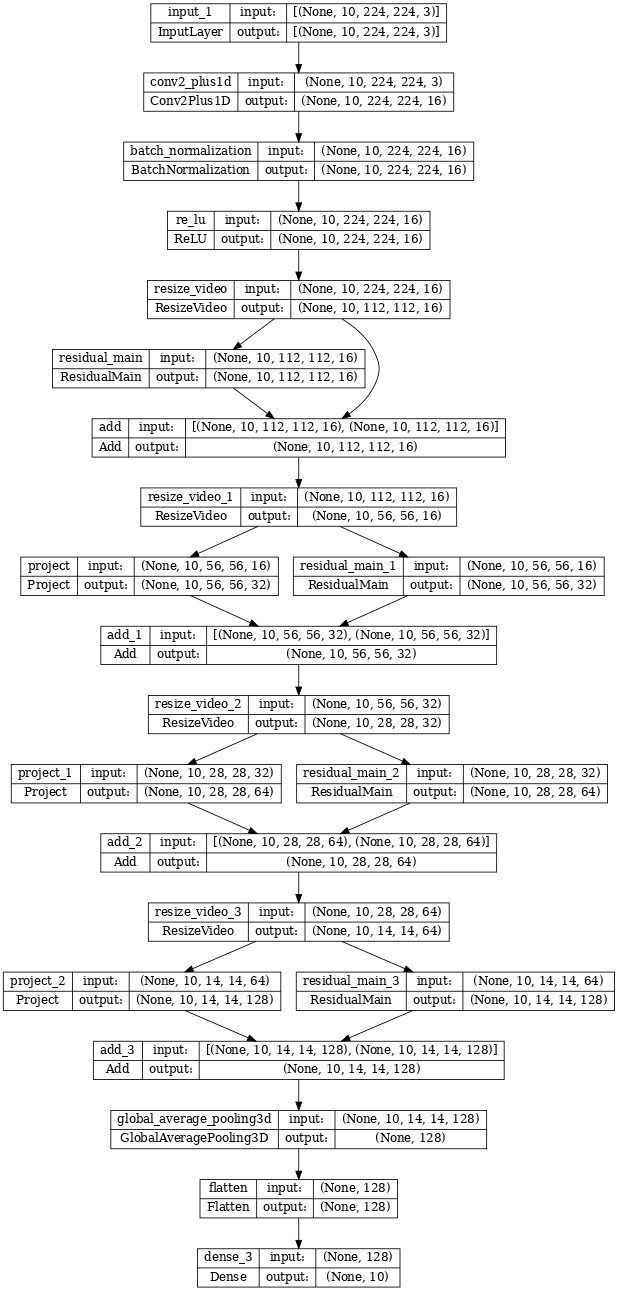

In [12]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [13]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [14]:
# CReate a customized callback so when val_acc > 94% it stops training
from keras.callbacks import EarlyStopping, ModelCheckpoint

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

bst_model_path = "src/"+model_type+"/bestmodels/best_"+model_name+"_{epoch:02d}_{val_accuracy:.2f}_model.h5"

callbacks = [
    #EarlyStopping(monitor="loss", patience=15),
    #EarlyStopping(monitor="accuracy", patience=15),
    ModelCheckpoint(filepath=bst_model_path, save_best_only=True, save_weights_only=True, monitor="val_accuracy", mode='max'),
    MyThresholdCallback(threshold=0.94)
    
]


In [15]:
history = model.fit(train_ds,
                    epochs=10, 
                    validation_data=val_ds,
                    callbacks=callbacks,
                    batch_size=batch_size)

Epoch 1/10


2023-04-29 19:11:13.371173: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2023-04-29 19:11:13.881606: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-29 19:11:14.266518: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


      6/Unknown - 9s 718ms/step - loss: 2.5352 - accuracy: 0.1458WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2981s vs `on_train_batch_end` time: 0.3527s). Check your callbacks.
     25/Unknown - 22s 723ms/step - loss: 2.4402 - accuracy: 0.1168

2023-04-29 19:11:46.136081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 1000
2023-04-29 19:11:49.182278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


25/25 [==============================] - 40s 1s/step - loss: 2.4402 - accuracy: 0.1168 - val_loss: 2.2639 - val_accuracy: 0.1167
Epoch 2/10
25/25 [==============================] - 19s 754ms/step - loss: 2.2265 - accuracy: 0.1574 - val_loss: 2.2035 - val_accuracy: 0.1333
Epoch 3/10
25/25 [==============================] - 19s 755ms/step - loss: 2.0835 - accuracy: 0.2513 - val_loss: 2.2023 - val_accuracy: 0.1500
Epoch 4/10
25/25 [==============================] - 19s 758ms/step - loss: 1.8521 - accuracy: 0.2995 - val_loss: 2.2945 - val_accuracy: 0.1833
Epoch 5/10
25/25 [==============================] - 19s 756ms/step - loss: 1.8136 - accuracy: 0.2919 - val_loss: 2.3864 - val_accuracy: 0.1333
Epoch 6/10
25/25 [==============================] - 19s 756ms/step - loss: 1.7344 - accuracy: 0.2995 - val_loss: 2.6086 - val_accuracy: 0.1333
Epoch 7/10
25/25 [==============================] - 19s 764ms/step - loss: 1.8050 - accuracy: 0.2944 - val_loss: 2.2341 - val_accuracy: 0.2000
Epoch 8/10
25

In [16]:
best_model_epoch = np.argmax(history.history['val_accuracy'])
best_acc, best_loss, best_val_acc, best_val_loss = history.history['accuracy'][best_model_epoch], history.history['loss'][best_model_epoch], history.history['val_accuracy'][best_model_epoch], history.history['val_loss'][best_model_epoch]

In [17]:
#best_model = tf.keras.models.load_model(f"src/{model_type}/bestmodels/best_{model_name}_{(best_model_epoch+1):02d}_{best_val_acc:.2f}_model.h5")

model.load_weights(f"src/{model_type}/bestmodels/best_{model_name}_{(best_model_epoch+1):02d}_{best_val_acc:.2f}_model.h5")

In [18]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_results = model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", test_results)

Evaluate on test data
3/3 [==============================] - 12s 4s/step - loss: 2.0989 - accuracy: 0.2174
test loss, test acc: [2.098907947540283, 0.21739129722118378]


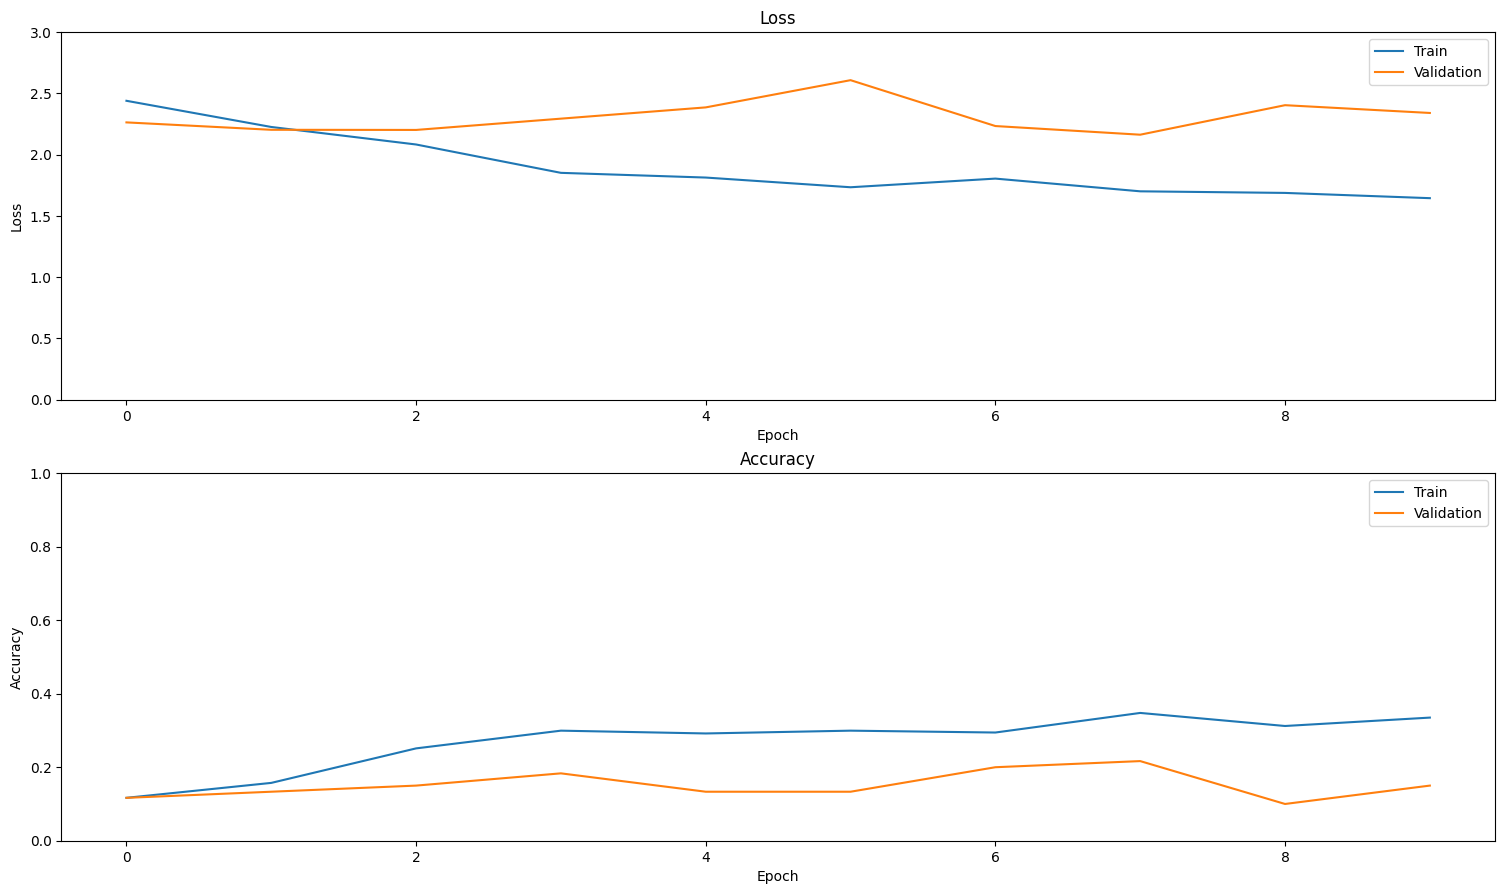

In [19]:
plot_history(history)

In [37]:
from src.leaderboard import Leaderboard

lb = Leaderboard()
lb.update_leaderboard(history=history,
                      test_results=test_results,
                      model_name=model_name,
                      model_type=model_type,
                      subset_size=subset_size)

lb.lb

,model_type,model_name,train_acc,val_acc,test_acc,train_loss,val_loss,test_loss,epoch,path_to_model,subset_size
0,mediapipe,mp,0.95,0.92,0.93,0.22,0.28,0.28,77.0,src/mediapipe/bestmodels/best_mp_77_0.92_model.h5,10.0
1,convlstm,simple,0.96,0.93,0.93,0.15,0.20,0.19,39.0,src/convlstm/bestmodels/best_simple_39_0.93_mo...,10.0
2,convlstm,stateless,0.93,0.95,0.91,0.22,0.19,0.19,22.0,src/convlstm/bestmodels/best_stateless_22_0.95...,10.0
3,3DCNN,3dcnn,0.35,0.22,0.22,1.70,2.16,2.10,8.0,src/3DCNN/bestmodels/best_3dcnn_8_0.22_model.h5,10.0
